In [37]:
#----------------------------------------------------------------------------
# Project     : Price Alarm System Enhancement - Alarm2
# Created By  : Eungi Cho
# Created Date: 03/06/22
# Updated Date: 20/06/22
# version ='Final_for_engineer'
# ---------------------------------------------------------------------------

'''
Import pandas, numpy, matplotlib to analyze data
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

'''
Import warnings module to ignore the future warning messages
'''
import warnings
warnings.filterwarnings("ignore")

'''
import time measurement module to track the progress
'''
from tqdm import tqdm
tqdm.pandas()

In [38]:
'''
Load data from provided csv file
'''
df_raw = pd.read_csv('/Users/cho-eungi/Practice/CSV/market_entry_price.csv')
df_raw = df_raw.drop_duplicates()
df_raw.head()

,source_id,country,market_id,product_id,entry_id,currency,final_unit,date,price_min,price_max,price_avg
0,16,China,2344,125,118227410,CNY,kg,2022-02-21,8.16,8.34,8.205000
1,16,China,2344,125,118227410,CNY,kg,2022-05-23,6.02,6.30,6.146667
2,16,China,2344,125,118227410,CNY,kg,2022-04-04,6.67,7.04,6.901667
3,16,China,2344,125,118227410,CNY,kg,2022-05-09,5.93,6.30,6.098000
4,16,China,2344,125,118227410,CNY,kg,2022-05-16,6.02,6.12,6.070000


# Data Pre-processsing
Step1: Randomly sampling 3000 entries to create 'sample_entry' (pd.DataFrame)

Step2: Join 'time_df' to each 'sample_entry', and make 'df' to reflect the actual frequency of price acquisition (W-MON)

In [39]:
'''
Randomly select 3,000 entries from df_raw to reduce processing time
'''

entry_lst = np.sort(df_raw['entry_id'].unique())
np.random.seed(0)
sample_entry = list(np.random.choice(entry_lst, 3000))
'''
Sort df_raw by values ['entry_id', 'date'] and name it as 'sample_df'  
'''
sample_df = df_raw.loc[df_raw['entry_id'].isin(sample_entry)].sort_values(
    by = ['entry_id', 'date']).copy()

'''
Change dtype of column 'date' to pd.Timestamp
'''
sample_df['date'] = pd.to_datetime(sample_df['date'])

In [40]:
# W-MON date range from 2020 to 2022
# Left Join Test DF and Time DF
'''
*** IMPORTANT ***
df_raw has the CHARACTERISTICS as below:
1) Frequency of price acquisition is every Monday (W-MON)
2) Column 'date' is a series of 'acquired dates'
   , that means it doesn't contain 'not acquired dates'.

Therefore, it needs a process to contain 'not acquired dates' in df_raw as well, 
for reflecting the 'actual' acquisition frequency by each entry.
'''

'''
Create empty dataframe first.
'''
empty_df = pd.DataFrame()
for entry in tqdm(sample_entry):
    '''
    Step 1: Find the first acquisition date (entry_start) by each entry
            , and create date timeseries range from {entry_start} to '2022-05-31'.
            ('2022-05-31' is used only for analysis)
    '''
    entry_start = min(sample_df.loc[sample_df['entry_id'] == entry]['date'])
    date_range = pd.date_range(entry_start, '2022-05-31', freq = 'W-MON')
    
    '''
    Step 2: Create 'time_df', and attach one column 'entry_id_'.
    '''
    time_df = pd.DataFrame({'date': date_range})
    time_df['entry_id_'] = entry
    
    '''
    Step 3: Left join 'time_df' to create 'joined_df', and append it to the 'empty_df'.
    '''
    entry_df = sample_df.loc[sample_df['entry_id'] == entry]
    joined_df = pd.merge(time_df, entry_df, left_on = ['date'], right_on = ['date'], how = 'left')
    empty_df = empty_df.append(joined_df)

empty_df = empty_df.drop(['entry_id'], axis = 1)

'''
Copy the result (empty_df) as 'df'
'''
df = empty_df.copy()
df = df.sort_values(by = ['entry_id_', 'date'])
df.set_index(np.arange(len(df)), inplace=True)
df.head()

100%|█████████████████████████████████████████████| 3000/3000 [01:20<00:00, 37.29it/s]


,date,entry_id_,source_id,country,market_id,product_id,currency,final_unit,price_min,price_max,price_avg
0,2020-01-13,40857158,44.0,Belgium,2100.0,164.0,EUR,kg,269.96,269.96,269.960000
1,2020-01-20,40857158,44.0,Belgium,2100.0,164.0,EUR,kg,268.44,269.96,268.657143
2,2020-01-27,40857158,44.0,Belgium,2100.0,164.0,EUR,kg,268.44,268.44,268.440000
3,2020-02-03,40857158,44.0,Belgium,2100.0,164.0,EUR,kg,268.39,268.44,268.404286
4,2020-02-10,40857158,44.0,Belgium,2100.0,164.0,EUR,kg,261.69,268.39,263.604286


# Define Alarm Function

step1: Find mode of frequency by each entry

step2: Calculate threshold by each entry

In [41]:
'''
df_stats contains only essential features in df.
'''
df_stats = df[['date', 'entry_id_', 'price_avg']]

In [42]:
def count_consec_nan(array):
    '''
    This function is defined to Count the occurances of consecutive null
    '''
    consec_cnt = array.isnull().astype(int).groupby(array.notnull().astype(int).cumsum()).cumsum()
    return np.asarray(consec_cnt)

'''
Count consecutive null by each entry, and add the result to new column 'consec_null'
'''
df['consec_null'] = df.groupby('entry_id_')['price_avg'].progress_transform(count_consec_nan)
df['consec_null_shift'] = df.groupby('entry_id_')['consec_null'].shift(1)

'''
conditions[0] = price that is acquired at the first time. Set frequency as 0
conditions[1] = acquired price that is acquired not at the first time. Set frequency as df['consec_null_shift']
Other = price not acquired. Set frequency as np.nan
'''
conditions  = [ (df['consec_null'] == 0) & (df['consec_null_shift'].isnull()),
               (df['consec_null'] == 0) & (df['consec_null_shift'].notnull())]
choices     = [ 0, df['consec_null_shift'] + 1]
df["freq"] = np.select(conditions, choices, default=np.nan)

'''
Calculate mode of frequency by each entry, and save the result to dictionary.
dictionary = {'entry_id': mode of frequency}

*** IMPORTANT ***
Most of the entries have only a single mode to be used as frequency, but some others are not.
They have reported prices unregularly since the first reported date, so they do have multiple modes.
'''
entry_freq = df.groupby('entry_id_')['freq'].agg(pd.Series.mode).to_dict()

100%|████████████████████████████████████████████| 2961/2961 [00:06<00:00, 472.37it/s]


In [43]:
def calculate_threshold(df, threshold_dict):
    '''
    This function is used to calculate threshold to raise alarm based on the mode of frequency.
    Return dictionary {'entry_id': threshold}
    
    Case 1: mode of frequency of the entry is a single value
        Case 1-1: 
            mode == 0 : It means the price has been acquired only one times ever.
            IF it hasn't been 2 month since the entry was added: set threshold as np.inf (do not raise alarm)
            ELSE                                               : set threshold as np.NINF (raise alarm unconditionally)
        Case 1-2:
            IF mode == 1 : set threshold as 4
            ELSE         : set threshold as mode * 2 
            
    Case 2: mode of frequency of the entry is a list containing multiple values.
        Case 2-1:
            mode == [0, 1]: It means the price has been acquired at the first & next time only.
            IF it hasn't been 2 month since the entry was added: set threshold as np.inf (do not raise alarm)
            ELSE                                               : set threshold as np.NINF (raise alarm unconditionally)
        Case 2-2:
            mode == [0, 1, 3, 6, ...] or [0, 3, 8, ...] : It means the price has been acquired unregularly multiple times.
            IF mode[1] == 1: set threshold as 4
            ELSE           : set threshold as mode[1] * 2
    '''
    threshold_dict = {}
    for entry, mode in tqdm(entry_freq.items()):
        # Calculate the timedelta between the first reported date and current date.
        timedelt = round((pd.Timestamp(2022, 6, 20) - min(df.loc[df['entry_id_'] == entry]['date'])) / np.timedelta64(1, 'M'))        
 
        # Case 1
        if isinstance(mode, float):
            # Case 1-1
            if mode == 0:
                if timedelt <= 2:
                    threshold_dict[entry] = np.inf
                else:
                    threshold_dict[entry] = np.NINF
            # Case 1-2
            else:
                if mode == 1:
                    threshold_dict[entry] = 4
                else:
                    threshold_dict[entry] = mode * 2
        
        # Case 2
        else:
            # Case 2-1
            if (len(mode) == 2) & (np.min(mode) == 0) & (mode[np.where(mode == np.min(mode))[0][0] + 1] == 1):
                if timedelt <= 2:
                    threshold_dict[entry] = np.inf
                else:
                    threshold_dict[entry] = np.NINF
                    
            # Case 2-2
            else:
                value = mode[np.where(mode == np.min(mode))[0][0] + 1]
                if value == 1:
                    value = mode[np.where(mode == np.min(mode))[0][0] + 2]
                    threshold_dict[entry] = value * 2
                else:
                    threshold_dict[entry] = value * 2
                    
    return threshold_dict

threshold_dict = calculate_threshold(df, entry_freq)

100%|████████████████████████████████████████████| 2961/2961 [00:03<00:00, 852.43it/s]


In [44]:
def find_threshold(row, threshold_dict):
    entry_id = row.unique()[0]
    threshold_col = [threshold_dict[entry_id]] * len(row)
    return np.asarray(threshold_col[0])

df['threshold'] = df.groupby('entry_id_')['entry_id_'].transform(lambda row: find_threshold(row, threshold_dict))

conditions  = [ (df['consec_null'] == 0) & (df['consec_null_shift'].isnull()),
                (df['consec_null'] == 0) & (df['consec_null_shift'].notnull()),
                (df['consec_null'] != 0) ]

choices     = [ 0, 1, df['consec_null']]
df["freq_judge"] = np.select(conditions, choices)

df['alarm'] = np.where(df['freq_judge'] > df['threshold'], 1, 0)

In [45]:
df_stats = pd.concat([df_stats, df[['consec_null', 'threshold', 'freq_judge', 'alarm']]], axis = 1)
df_stats.head()

,date,entry_id_,price_avg,consec_null,threshold,freq_judge,alarm
0,2020-01-13,40857158,269.960000,0,4.0,0,0
1,2020-01-20,40857158,268.657143,0,4.0,1,0
2,2020-01-27,40857158,268.440000,0,4.0,1,0
3,2020-02-03,40857158,268.404286,0,4.0,1,0
4,2020-02-10,40857158,263.604286,0,4.0,1,0


# Plot Sample

In [46]:
df_stats_pivot = df_stats.pivot_table(['price_avg', 'alarm', 'threshold'], columns = ['date'], index = ['entry_id_'])

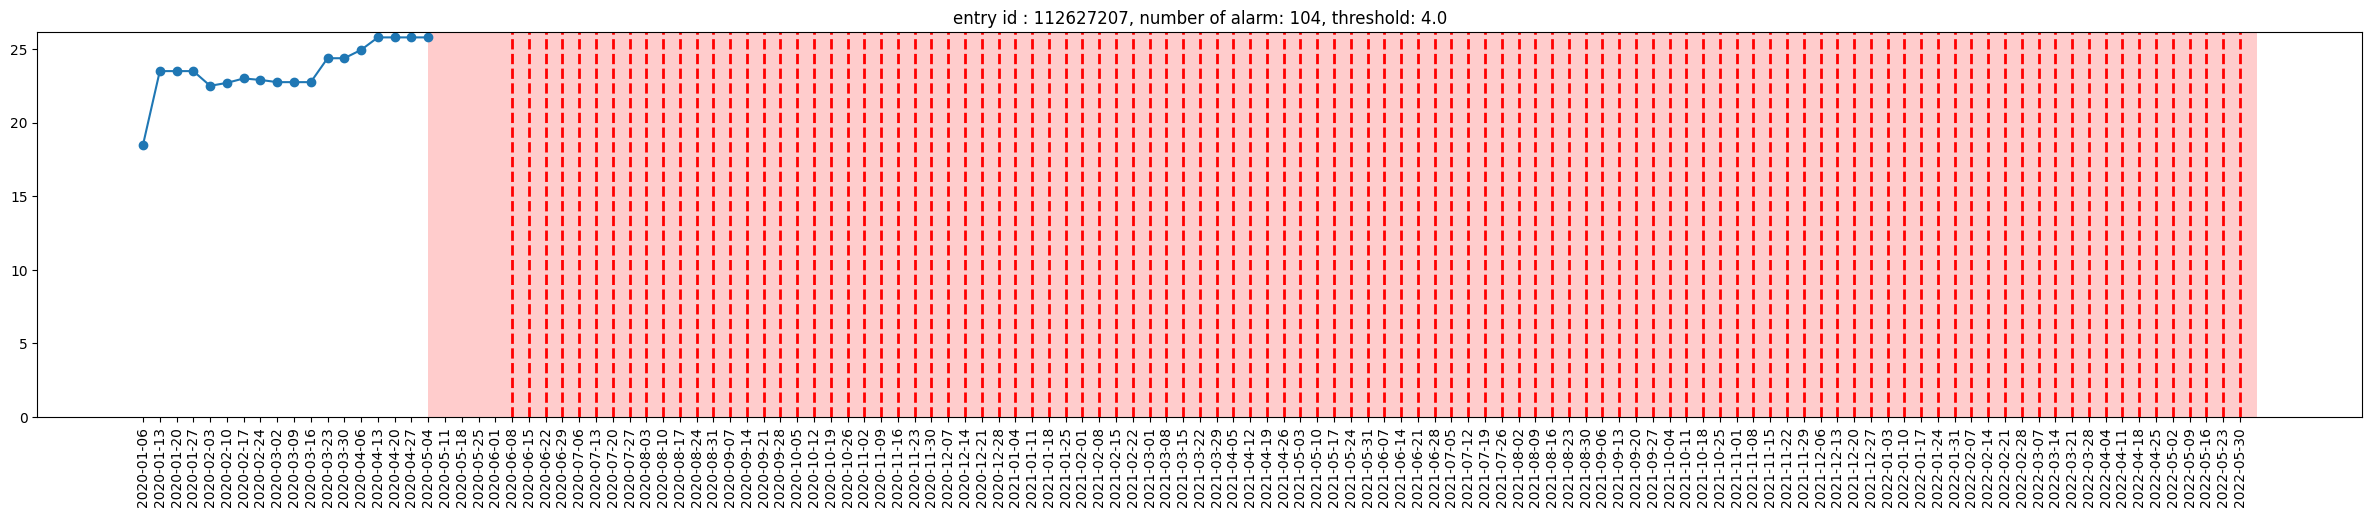

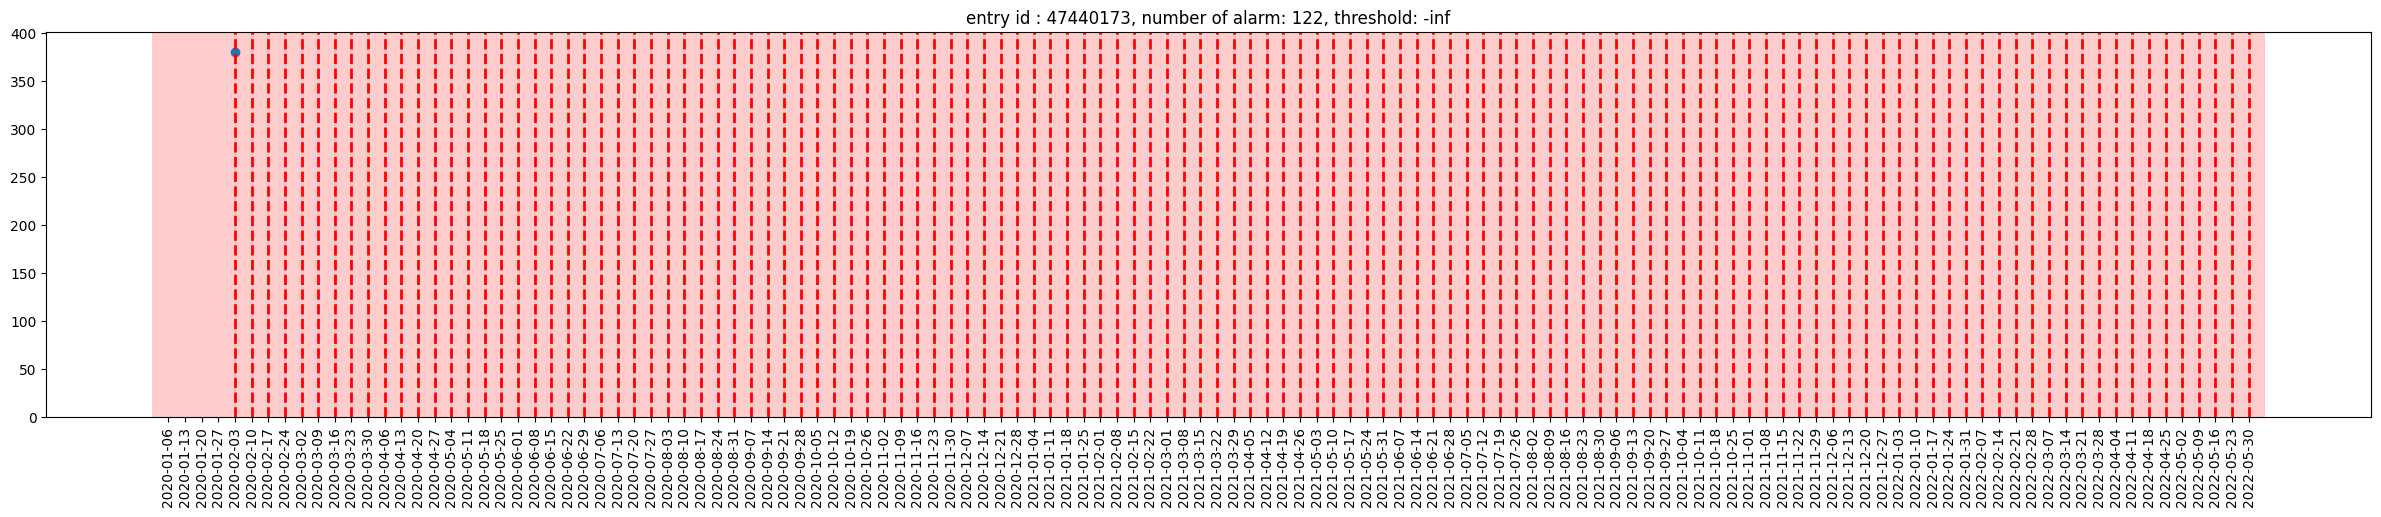

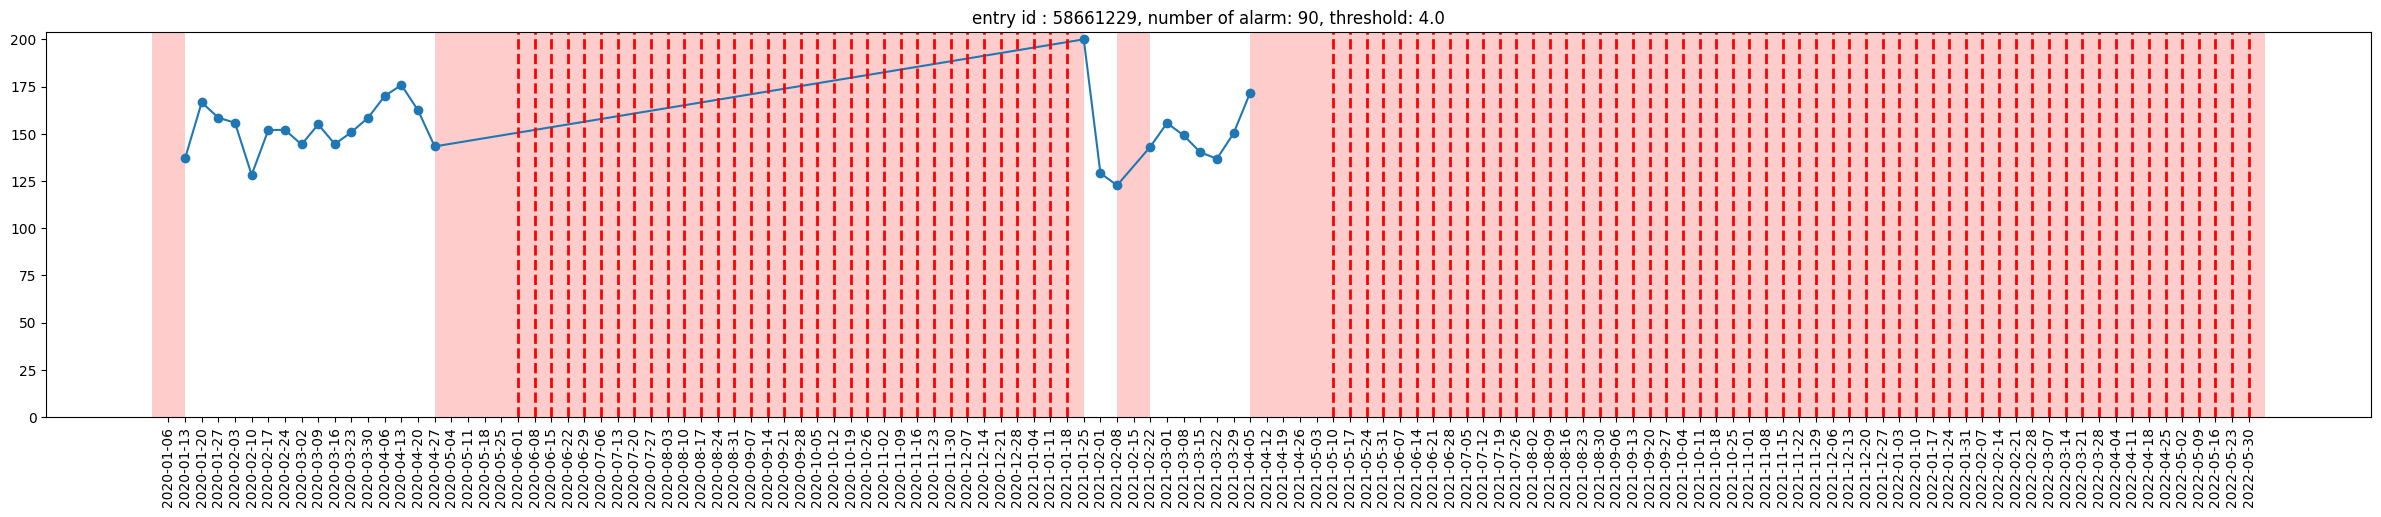

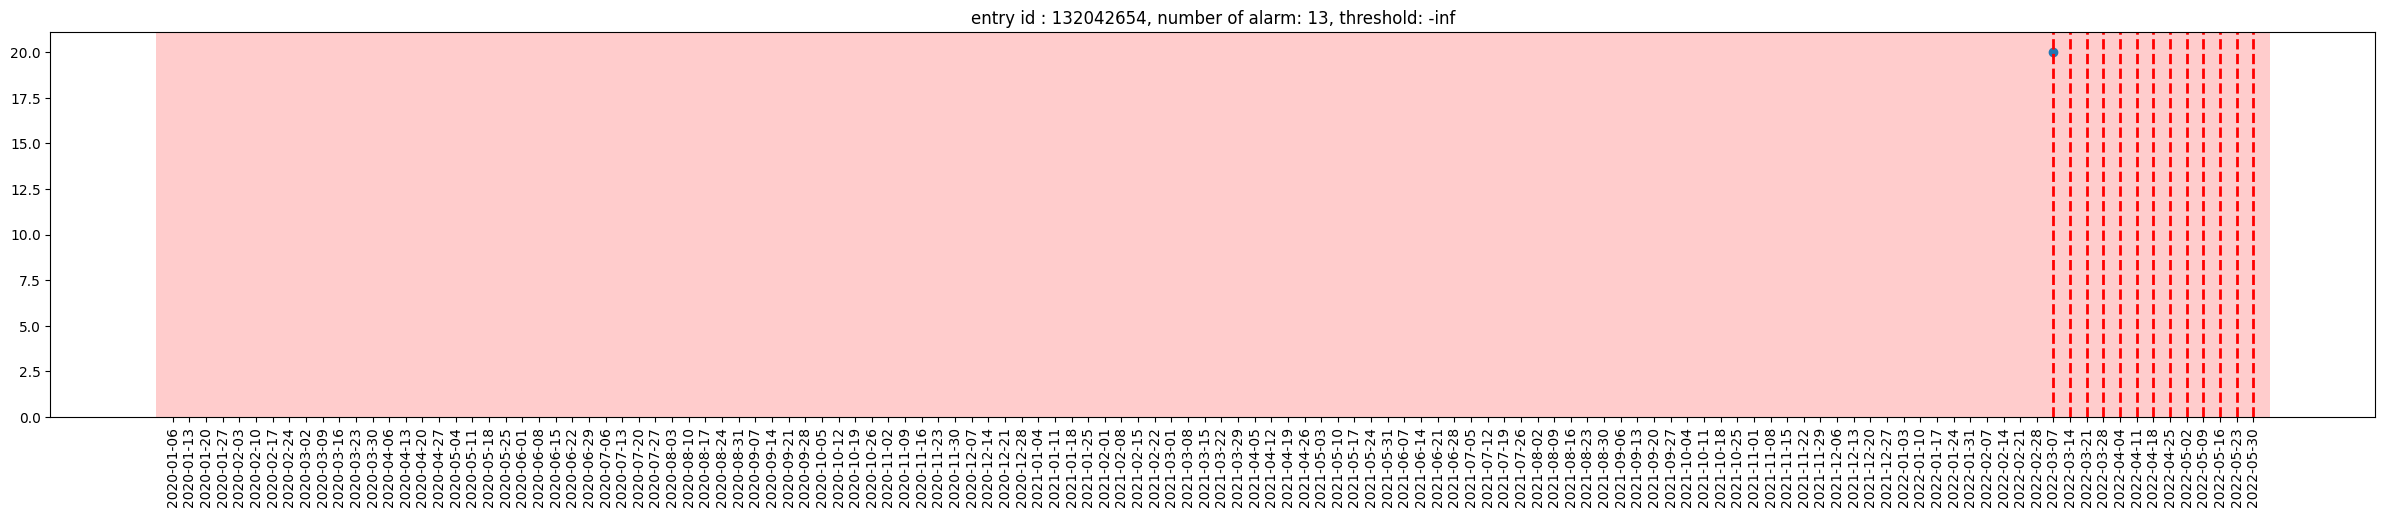

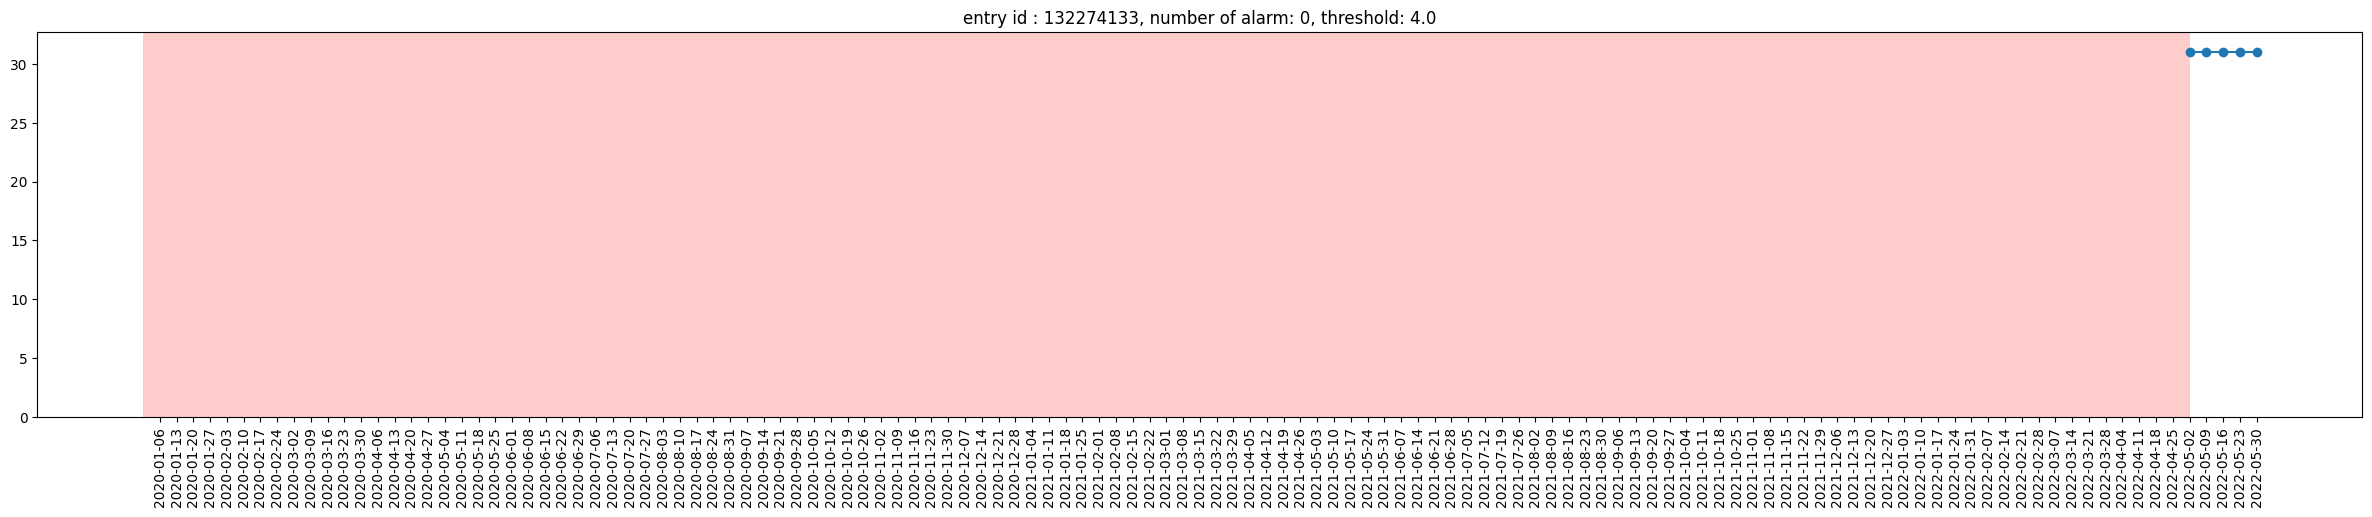

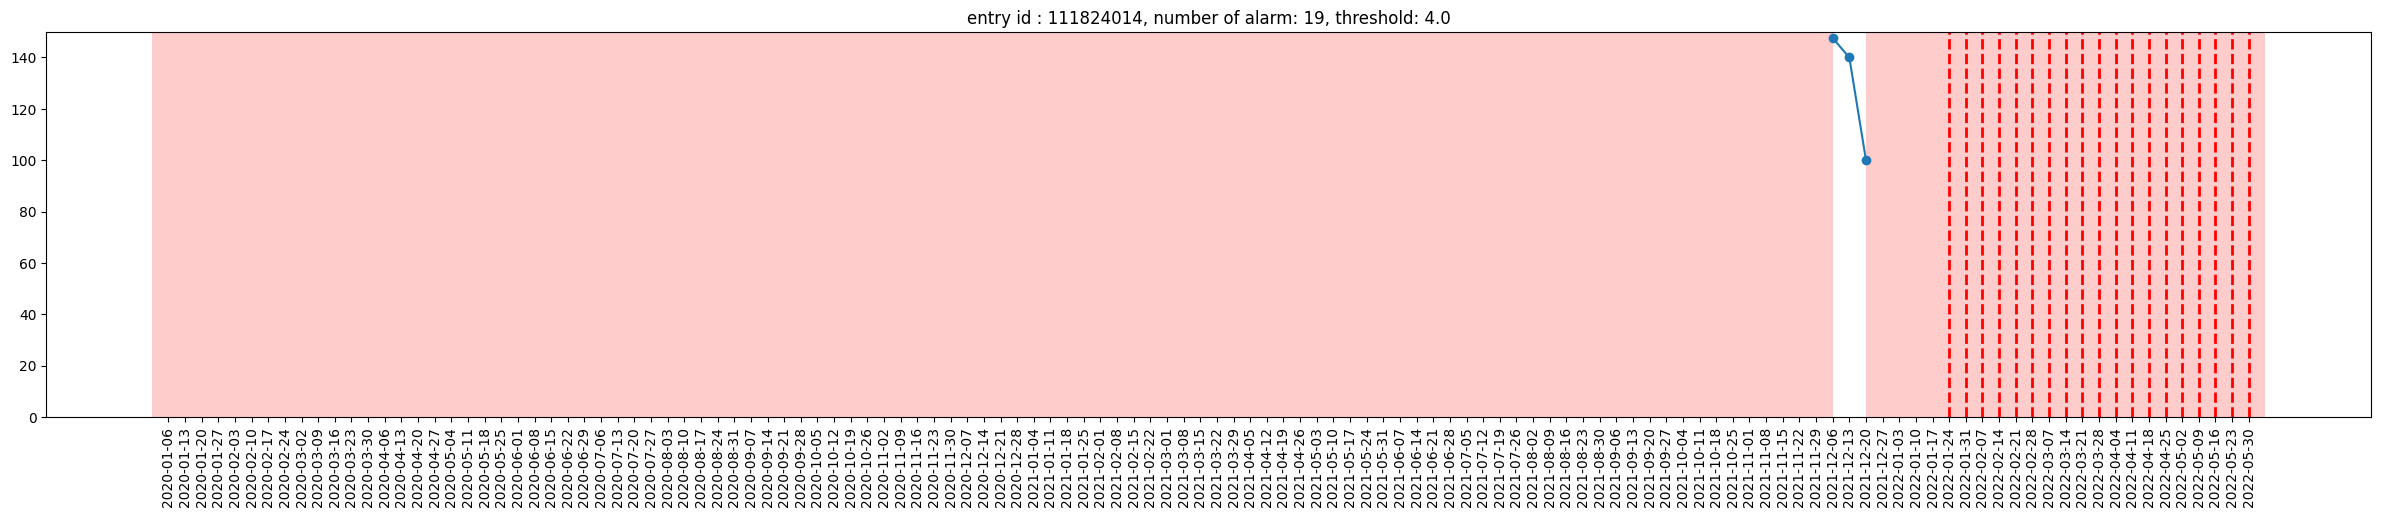

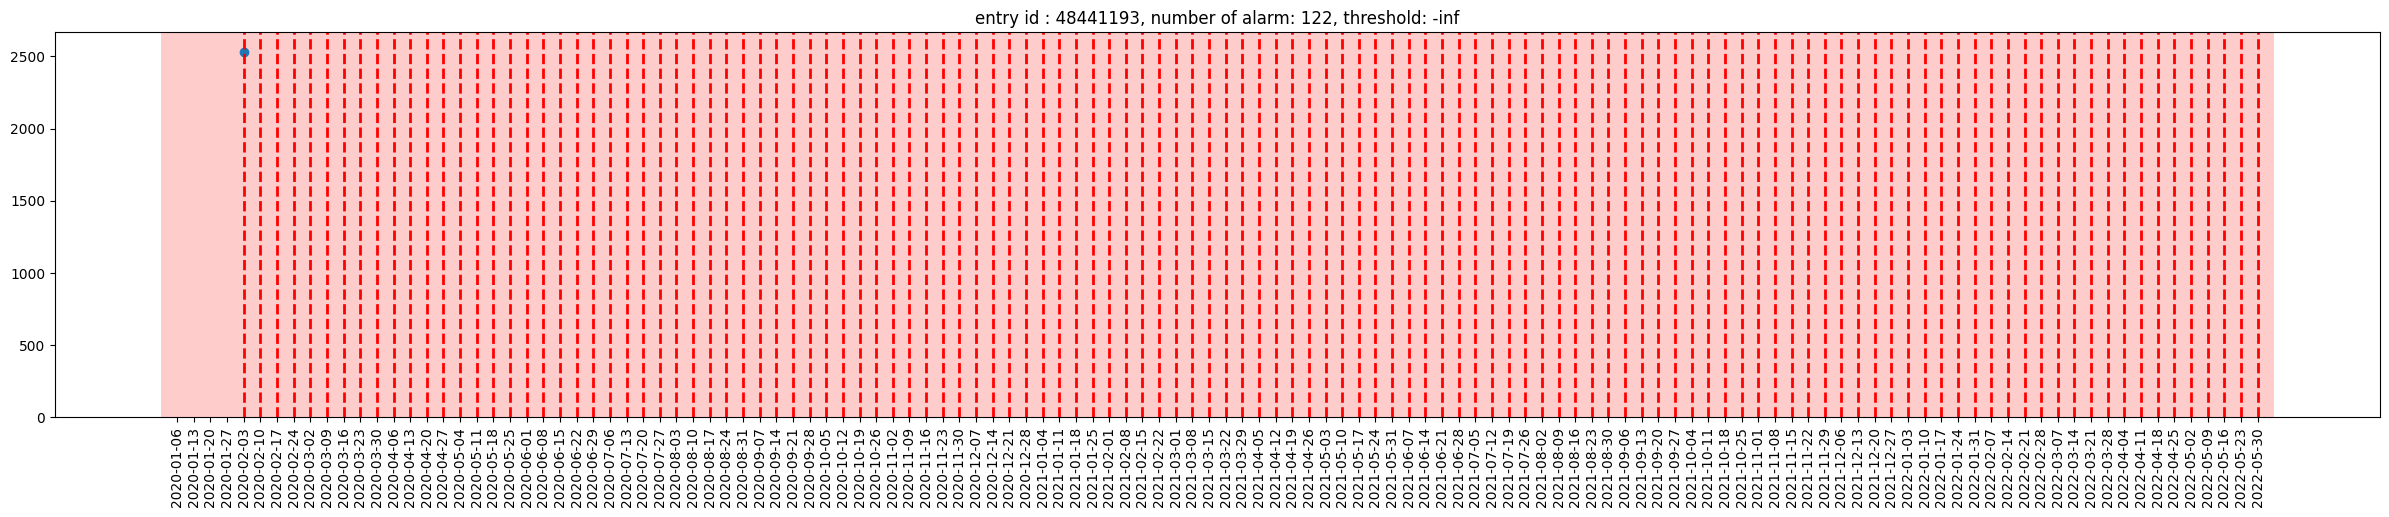

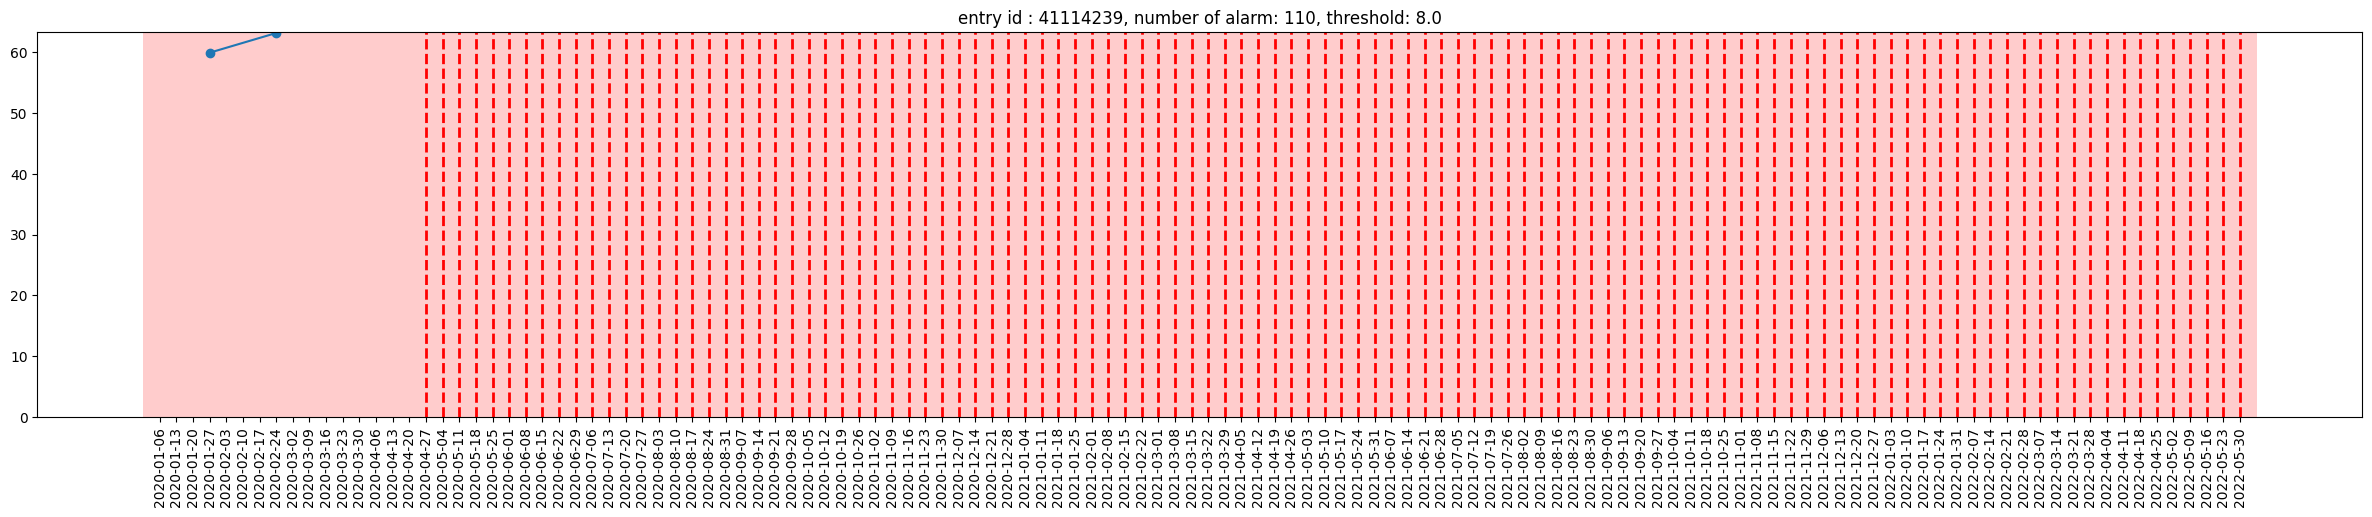

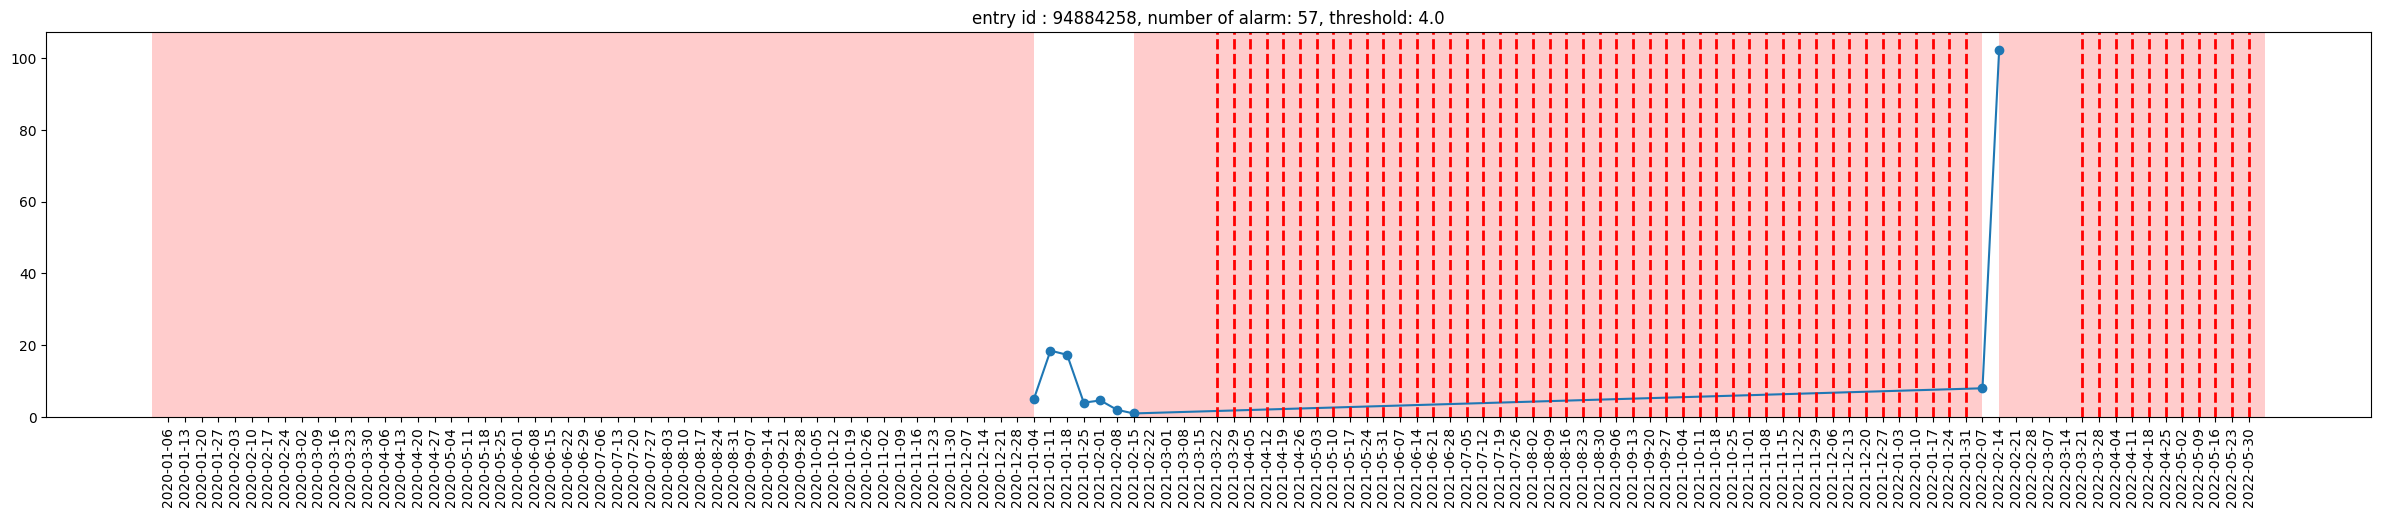

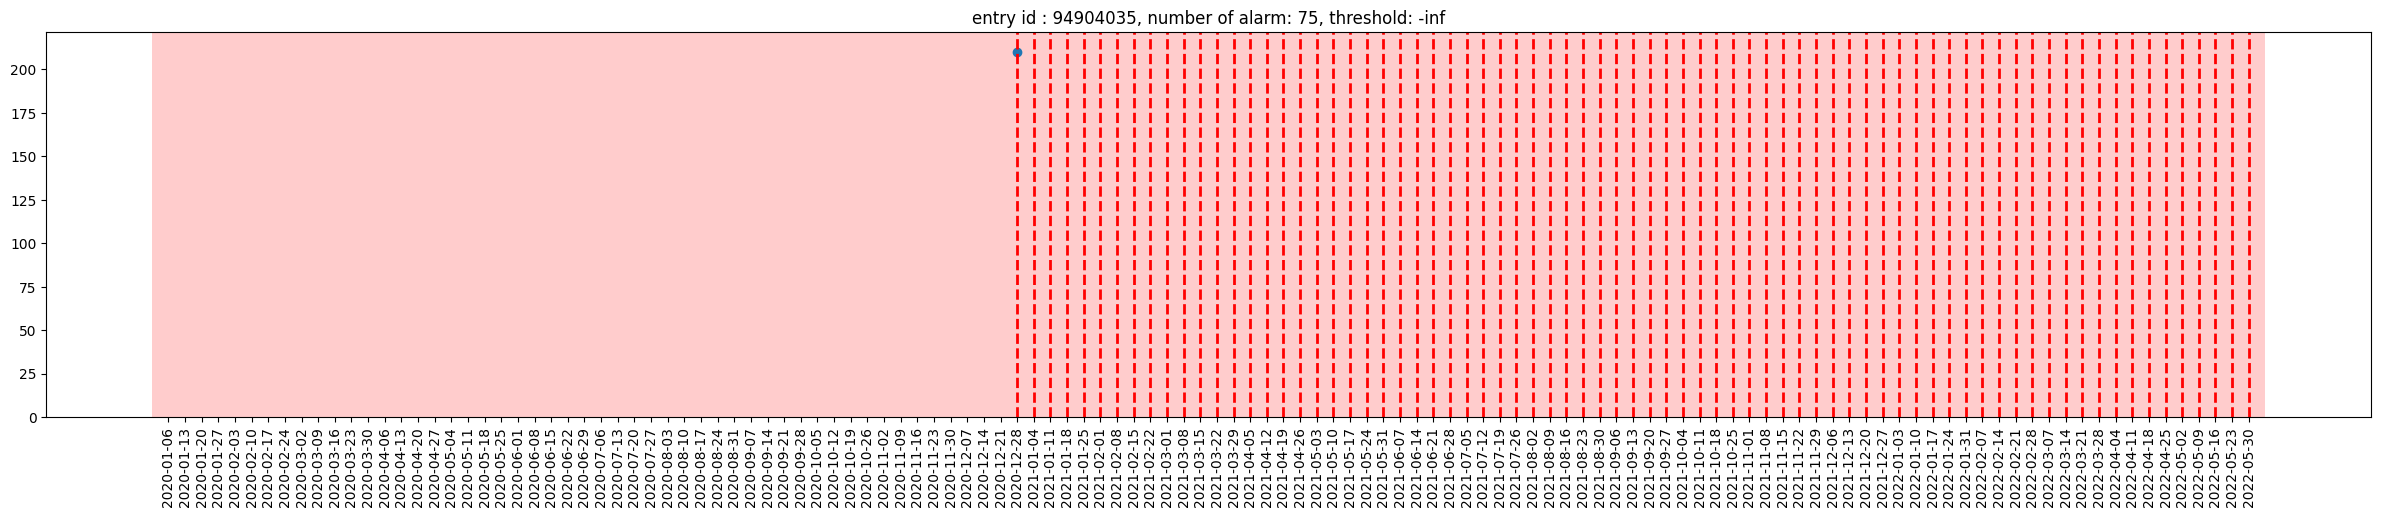

In [52]:
# Define function: Plot sample data with full time period
def plot_sample_with_ft(df_pivot, entry_id):
    # Masking null_value
    sample_entry = df_pivot[df_pivot.index == entry_id].stack(dropna = False).reset_index().drop(['entry_id_'], axis = 1)
    x = sample_entry.date
    y = sample_entry.price_avg.astype(np.double)
    alarm_x = sample_entry[sample_entry['alarm'] == 1].date
    ymask = np.isfinite(y)
    
    plt.figure(figsize = (30, 5))
    plt.plot(x[ymask], y[ymask], linestyle = '-', marker = 'o')
    for i in range(len(alarm_x)):
        plt.axvline(x=alarm_x.iat[i], color='r', linestyle='--', linewidth=2, label = 'new_alarm')
    plt.xticks(sample_entry.date, rotation = 90)
    plt.title(f'entry id : {entry_id}, number of alarm: {len(alarm_x)}, threshold: {sample_entry.threshold.mean()}')
    plt.ylim(bottom = 0)
    
    # axvspan with red color - find index of start & end point of null
    sample_entry = sample_entry.set_index('date')
    is_nan = sample_entry['price_avg'].isna()
    n_groups = is_nan.ne(is_nan.shift()).cumsum()
    
    if len(sample_entry[is_nan].groupby(n_groups).groups) >= 1:
        gap_list = sample_entry[is_nan].groupby(n_groups).aggregate(
            lambda x: (
                x.index[0] + pd.DateOffset(days=-7),
                x.index[-1] + pd.DateOffset(days=+7)
            )
        )["price_avg"].values
    
        for gap in gap_list:
            plt.axvspan(gap[0], gap[1], facecolor='r', alpha=0.2)
        
    plt.style.use('default')
    plt.show()

for entry in sample_entry[:10]:
    plot_sample_with_ft(df_pivot = df_stats_pivot, entry_id = entry)